# DCTによる圧縮画像を作る

In [1]:
import numpy as np
import scipy.misc
from scipy.fftpack import dct, idct
import sys
from PIL import Image
import matplotlib
import matplotlib.pyplot as plt
import random
from tqdm import tqdm_notebook as tqdm
from tqdm._tqdm_notebook import tqdm_notebook
from scipy.fftpack import dct, idct
import seaborn as sns
from skimage.metrics import structural_similarity as ssim
import pandas as pd

%matplotlib inline


class ImageLoader:
    def __init__(self, FILE_PATH):
        self.img = np.array(Image.open(FILE_PATH))
        # 行数
        self.row_blocks_count = self.img.shape[0] // 8
        # 列数
        self.col_blocks_count = self.img.shape[1] // 8

    def get_points(self, POINT):
        Row = random.randint(0, len(self.img) - POINT - 1)
        Col = random.randint(0, len(self.img) - 1)
        return self.img[Row : Row + POINT, Col]

    def get_block(self, col, row):
        return self.img[col * 8 : (col + 1) * 8, row * 8 : (row + 1) * 8]


# plt.rcParams['font.family'] ='sans-serif'#使用するフォント
# plt.rcParams["font.sans-serif"] = "Source Han Sans"
plt.rcParams["font.family"] = "Source Han Sans JP"  # 使用するフォント
plt.rcParams["xtick.direction"] = "in"  # x軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams["ytick.direction"] = "in"  # y軸の目盛線が内向き('in')か外向き('out')か双方向か('inout')
plt.rcParams["xtick.major.width"] = 1.0  # x軸主目盛り線の線幅
plt.rcParams["ytick.major.width"] = 1.0  # y軸主目盛り線の線幅
plt.rcParams["font.size"] = 12  # フォントの大きさ
plt.rcParams["axes.linewidth"] = 1.0  # 軸の線幅edge linewidth。囲みの太さ
matplotlib.font_manager._rebuild()

# 画像の用意
MONO_DIR_PATH = "../../Mono/"
AIRPLANE = ImageLoader(MONO_DIR_PATH + "airplane512.bmp")
BARBARA = ImageLoader(MONO_DIR_PATH + "barbara512.bmp")
BOAT = ImageLoader(MONO_DIR_PATH + "boat512.bmp")
GOLDHILL = ImageLoader(MONO_DIR_PATH + "goldhill512.bmp")
LENNA = ImageLoader(MONO_DIR_PATH + "lenna512.bmp")
MANDRILL = ImageLoader(MONO_DIR_PATH + "mandrill512.bmp")
MILKDROP = ImageLoader(MONO_DIR_PATH + "milkdrop512.bmp")
SAILBOAT = ImageLoader(MONO_DIR_PATH + "sailboat512.bmp")

N = 16

# DCT

## 基底関数

$$
\phi_k[i] = \begin{cases}
\cfrac{1}{\sqrt{N}}  \quad \quad \quad (k=0) \\
\sqrt{\cfrac{2}{N}} \cos \left({\cfrac{\pi}{2N}(2i+1)k}\right) \quad  (k=1,2,...,N-1) 
\end{cases}
$$

In [2]:
class DCT:
    def __init__(self, N):
        self.N = N  # データ数
        # 1次元DCTの基底ベクトルの生成
        self.phi_1d = np.array([self.phi(i) for i in range(self.N)])
        # 2次元DCTの基底ベクトルの格納
        self.phi_2d = np.zeros((N, N))

    def phi(self, k):
        """ 離散コサイン変換(DCT)の基底関数 """
        # DCT-II
        if k == 0:
            return np.ones(self.N) / np.sqrt(self.N)
        else:
            return np.sqrt(2.0 / self.N) * np.cos(
                (k * np.pi / (2 * self.N)) * (np.arange(self.N) * 2 + 1)
            )

    def dct(self, data):
        """ 1次元離散コサイン変換を行う """
        return self.phi_1d.dot(data)

    def idct(self, c):
        """ 1次元離散コサイン逆変換を行う """
        return np.sum(self.phi_1d.T * c, axis=1)

    def get_dct2_phi(self, y, x):
        """ 2次元離散コサイン変換の基底を返す """
        phi_x, phi_y = np.meshgrid(self.phi_1d[x], self.phi_1d[y])
        return phi_x * phi_y

    def get_dct2(self, y, x, data):
        """ i,jの2次元DCT係数を返す """
        phi_2d_phi = np.zeros((self.N, self.N))
        phi_2d_phi = self.get_dct2_phi(y, x)
        return np.sum(np.sum(phi_2d_phi * data))

    def dct2(self, data):
        """ 2次元離散コサイン変換を行う """
        for y in range(self.N):
            for x in range(self.N):
                self.phi_2d[y, x] = self.get_dct2(y, x, data)

        return self.phi_2d

    def idct2(self, c):
        """ 2次元離散コサイン逆変換を行う """
        idct2_data = np.zeros((self.N, self.N))
        phi_2d_phi = np.zeros((self.N, self.N))
        for y in range(self.N):
            for x in range(self.N):
                phi_2d_phi = self.get_dct2_phi(y, x)
                idct2_data += c[y, x] * phi_2d_phi

        return idct2_data

# MSDS

In [3]:
def msds(N,arr):
    w_e = 0
    e_e = 0
    n_e = 0
    s_e = 0
    nw_e = 0
    ne_e = 0
    sw_e = 0
    se_e = 0
    for row in range(arr.shape[0] // N):
        for col in range(arr.shape[1] // N):
            f_block = arr[row * N : (row + 1) * N, col * N : (col + 1) * N]
            # w
            if col == 0:
                w_block = np.fliplr(f_block)
            else:
                w_block = arr[row * N : (row + 1) * N, (col - 1) * N : col * N]
            # e
            if col == arr.shape[1] // N - 1:
                e_block = np.fliplr(f_block)
            else:
                e_block = arr[row * N : (row + 1) * N, (col + 1) * N : (col + 2) * N]
            # n
            if row == 0:
                n_block = np.flipud(f_block)
            else:
                n_block = arr[(row - 1) * N : row * N, col * N : (col + 1) * N]
            # s
            if row == arr.shape[0] // N - 1:
                s_block = np.flipud(f_block)
            else:
                s_block = arr[(row + 1) * N : (row + 2) * N, col * N : (col + 1) * N]

            w_d1 = f_block[:, 0] - w_block[:, N-1]
            e_d1 = f_block[:, N-1] - e_block[:, 0]
            n_d1 = f_block[0, :] - n_block[N-1, :]
            s_d1 = f_block[N-1, :] - s_block[0, :]

            w_d2 = (w_block[:, N-1] - w_block[:, N-2] + f_block[:, 1] - f_block[:, 0]) / 2
            e_d2 = (e_block[:, 1] - e_block[:, 0] + f_block[:, N-1] - f_block[:, N-2]) / 2
            n_d2 = (n_block[N-1, :] - n_block[N-2, :] + f_block[1, :] - f_block[0, :]) / 2
            s_d2 = (s_block[1, :] - s_block[0, :] + f_block[N-1, :] - f_block[N-2, :]) / 2

            w_e += np.sum((w_d1 - w_d2) ** 2 )
            e_e += np.sum((e_d1 - e_d2) ** 2 )
            n_e += np.sum((n_d1 - n_d2) ** 2)
            s_e += np.sum((s_d1 - s_d2) ** 2)

            # nw
            if row == 0 or col == 0:
                nw_block = np.flipud(np.fliplr(f_block))
            else:
                nw_block = arr[(row - 1) * N : row * N, (col - 1) * N : col * N]
            # ne
            if row == 0 or col == arr.shape[1] // N - 1:
                ne_block = np.flipud(np.fliplr(f_block))
            else:
                ne_block = arr[(row-1) * N : row * N, (col + 1) * N : (col + 2) * N]
            # sw
            if row == arr.shape[0] // N -1 or col == 0:
                sw_block = np.flipud(np.fliplr(f_block))
            else:
                sw_block = arr[row * N : (row+1) * N, (col-1) * N : col * N]
            # se
            if  row == arr.shape[0]//N-1 or col == arr.shape[0] // N -1:
                se_block = np.flipud(np.fliplr(f_block))
            else:
                se_block = arr[(row + 1) * N : (row + 2) * N, (col+1) * N : (col + 2) * N]

            nw_g1 = f_block[0, 0] - nw_block[N-1, N-1]
            ne_g1 = f_block[0, N-1] - ne_block[N-1, 0]
            sw_g1 = f_block[N-1, 0] - sw_block[0, N-1]
            se_g1 = f_block[N-1, N-1] - se_block[0, 0]

            nw_g2 = (nw_block[N-1,N-1] - nw_block[N-2,N-2] + f_block[1,1] - f_block[0,0])/2
            ne_g2 = (ne_block[N-1,0] - ne_block[N-2,1] + f_block[1,N-2] - f_block[0,N-1])/2
            sw_g2 = (sw_block[0,N-1] - nw_block[1,N-2] + f_block[N-2,1] - f_block[N-1,0])/2
            se_g2 = (nw_block[0,0] - nw_block[1,1] + f_block[N-2,N-2] - f_block[N-1,N-1])/2

            nw_e += (nw_g1 - nw_g2) ** 2 
            ne_e += (ne_g1 - ne_g2) ** 2 
            sw_e += (sw_g1 - sw_g2) ** 2 
            se_e += (se_g1 - se_g2) ** 2 

    MSDSt = (w_e + e_e + n_e + s_e + nw_e + ne_e + sw_e + se_e)/ ((arr.shape[0]/N)**2)
    MSDS1 = (w_e + e_e + n_e + s_e)/ ((arr.shape[0]/N)**2)
    MSDS2 = (nw_e + ne_e + sw_e + se_e)/ ((arr.shape[0]/N)**2)
    return MSDSt, MSDS1, MSDS2

# 16x16ブロックでDCT

### DCT

In [4]:
IMG = SAILBOAT

In [5]:
Fk = np.zeros(IMG.img.shape)

In [6]:
for row in range(IMG.img.shape[0] // 16):
    for col in range(IMG.img.shape[1] // 16):
        block = IMG.img[row * 16 : (row + 1) * 16, col * 16 : (col + 1) * 16]
        c = scipy.fftpack.dct(
            scipy.fftpack.dct(block, axis=0, norm="ortho"), axis=1, norm="ortho"
        )
        Fk[row * 16 : (row + 1) * 16, col * 16 : (col + 1) * 16] = c
        

In [7]:
low_3_value = 0
others_value = 0

In [8]:
for row in range(IMG.img.shape[0] // 16):
    for col in range(IMG.img.shape[1] // 16):
        block = Fk[row * 16 : (row + 1) * 16, col * 16 : (col + 1) * 16]
        low_3_value += np.abs(block[0, 1]) + np.abs(block[1, 0]) + np.abs(block[1, 1])
        others_value += (
            np.sum(np.sum(np.abs(block)))
            - np.abs(block[0, 0])
            - np.abs(block[0, 1])
            - np.abs(block[1, 0])
            - np.abs(block[1, 1])
        )
        

### 低域3成分 (0,1)(1,0)(1,1)の絶対値の和

In [9]:
low_3_value

360801.5162892417

In [10]:
others_value

2333357.016631969

### IDCT

In [11]:
recover = np.zeros(Fk.shape)

In [12]:
for row in range(Fk.shape[0] // 16):
    for col in range(Fk.shape[1] // 16):
        block = Fk[row * 16 : (row + 1) * 16, col * 16 : (col + 1) * 16]
        data = scipy.fftpack.idct(
            scipy.fftpack.idct(block, axis=0, norm="ortho"), axis=1, norm="ortho"
        )
        recover[row * 16 : (row + 1) * 16, col * 16 : (col + 1) * 16] = data
        

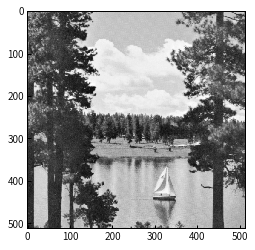

In [13]:
plt.imshow(recover, cmap="gray")

In [14]:
recover[0, 0:10]

array([30., 13., 15., 18., 19., 15., 15., 12., 15., 18.])

In [15]:
IMG.img[0, 0:10]

array([30, 13, 15, 18, 19, 15, 15, 12, 15, 18], dtype=uint8)

ちゃんと復元できてる

# 量子化テーブル

16x16の量子化テーブルは無いので一様量子化を行う

In [16]:
for i in tqdm_notebook(np.arange(1,1600,1)):
    Q = 200 - i/8
    Q_Luminance = np.ones((16,16)) * Q

    Q_Fk = np.zeros(Fk.shape)
    for row in range(IMG.img.shape[0] // 16):
        for col in range(IMG.img.shape[1] // 16):
            block = Fk[row * 16 : (row + 1) * 16, col * 16 : (col + 1) * 16]
            # 量子化
            block = np.round(block / Q_Luminance)
            # 逆量子化
            block = block * Q_Luminance
            Q_Fk[row * 16 : (row + 1) * 16, col * 16 : (col + 1) * 16] = block


    Q_recover = np.zeros(Q_Fk.shape)
    for row in range(Q_Fk.shape[0] // 16):
        for col in range(Q_Fk.shape[1] // 16):
            block = Q_Fk[row * 16 : (row + 1) * 16, col * 16 : (col + 1) * 16]
            data = scipy.fftpack.idct(
                scipy.fftpack.idct(block, axis=0, norm="ortho"), axis=1, norm="ortho"
            )
            Q_recover[row * 16 : (row + 1) * 16, col * 16 : (col + 1) * 16] = data

    Q_recover = np.round(Q_recover)
    qfk = pd.Series(Q_Fk.flatten())
    pro = qfk.value_counts() / qfk.value_counts().sum()
    S = 0
    for pi in pro:
        S -= pi * np.log2(pi)

    bpp = np.arange(0.2,0.8,0.05)
    for i in bpp:
        if np.abs(i - S) < 0.003:
            MSE = np.sum(np.sum(np.power((IMG.img - Q_recover), 2))) / (
                Q_Fk.shape[0] * Q_Fk.shape[1]
            )
            PSNR = 10 * np.log10(255 * 255 / MSE)
            MSSIM = ssim(IMG.img,Q_recover.astype(IMG.img.dtype),gaussian_weights=True,sigma=1.5,K1=0.01,K2=0.03)
            MSDSt, MSDS1, MSDS2 = msds(16,Q_recover)

            print("S=",S)
            print(Q,PSNR,MSSIM,MSDS1,MSDS2)
 

S= 0.1970107881670709
175.875 24.331157133080772 0.6351678665577808 54244.19921875 11638.562744140625
S= 0.19713715929386905
175.75 24.335175598558457 0.635314273503379 54238.7958984375 11623.030517578125
S= 0.19728618671028725
175.625 24.3391411141875 0.6350932741745631 54129.28955078125 11643.596435546875
S= 0.1973679094222288
175.5 24.34516460997176 0.6352069219073282 54063.7578125 11632.8330078125
S= 0.19744434426819346
175.375 24.344926392039362 0.6349909331556668 54056.47607421875 11607.24755859375
S= 0.19767990790499712
175.25 24.347424588572796 0.6350149165840212 53910.1806640625 11546.384521484375
S= 0.1979158800473354
175.125 24.349599733626327 0.6350444328593645 53974.65087890625 11503.12109375
S= 0.19803877360154595
175.0 24.352419605484243 0.6350084710166461 53904.263671875 11515.126708984375
S= 0.19810603028189927
174.875 24.356743758408715 0.635633083715641 53851.0908203125 11534.931396484375
S= 0.19819843946309976
174.75 24.361459260995755 0.6360949792857421 53919.37451

# 量子化

# IDCT

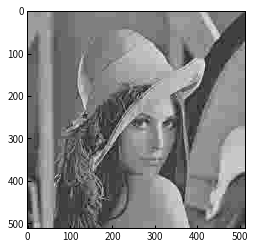

In [21]:
plt.imshow(Q_recover, cmap="gray")
# plt.imsave("DCT_8x8_LENNA.png",Q_recover,cmap="gray")

# 情報量

$$
- \sum ^{255}_{i=0} p_i log_2 p_i
$$

 0.0       0.988617
-200.0     0.003281
 200.0     0.003090
 2400.0    0.000446
 400.0     0.000439
dtype: float64

In [24]:
S

0.12762986512618407

# PSNR

$$
PSNR = 10 log_{10} \frac{MAX^2}{MSE}
$$

$$
{MSE = \frac{1}{m \, n} \sum^{m-1}_{i=0} \sum^{n-1}_{j=0} [ I(i,j) - K(i,j) ]^2}
$$

In [27]:
PSNR

26.295733096638152

# MSSIM

0.7026390012376981

In [30]:
MSDS1

35151.2109375

In [31]:
MSDS2

5829.85986328125